In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from math import pi
from math import exp
from random import randrange
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
import time 
import seaborn as sn
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv(r'subsetkdd99_proc.csv')


In [3]:
columnsinput = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","lnum_compromised","lroot_shell","lsu_attempted","lnum_root",
    "lnum_file_creations","lnum_shells","lnum_access_files",
    "is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

columnsmislab = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","lnum_compromised","lroot_shell","lsu_attempted","lnum_root",
    "lnum_file_creations","lnum_shells","lnum_access_files",
    "is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]

class_dict = {}

new_list=np.unique(data["label"])

for class_value in new_list:
    
    all_rows = data.loc[data.label ==class_value]
    class_dict[class_value]=all_rows 


In [4]:
col_summaries= {}

for classval,rowsval in class_dict.items():
    new_dataframe=pd.DataFrame(rowsval,columns=columnsmislab)   
   
    class_list=[]
    for cols in new_dataframe.columns:
        sumry_list=[np.mean(new_dataframe[cols])]
        sumry_list.append(np.std(new_dataframe[cols]))
        sumry_list.append(len(new_dataframe[cols]))
        class_list.append(sumry_list)
    col_summaries[classval]=class_list
    

In [5]:
def gaussiancal(rowval, mean, standev):   
    
    if standev==0:
        standev=0.00001
    mulfactor = exp(-((rowval-mean)**2 / (2 * standev**2 )))
    return (1 / (sqrt(2 * pi) * standev)) * mulfactor


In [6]:
def prob_per_class(col_summaries, row):
    
    total_rows = sum([col_summaries[label][0][2] for label in col_summaries])
    probabilities = dict()
    
    for class_value, class_summaries in col_summaries.items():
        
        probabilities[class_value] = col_summaries[class_value][0][2]/float(total_rows)
        
        for i in range(len(class_summaries)):
            
            mean, stdev, count = class_summaries[i]
            probabilities[class_value] = probabilities[class_value] * gaussiancal(row[i], mean, stdev)
            
    return probabilities

In [7]:
def splitting_data(dataset, crossfolds):
    
    dataset_split = []
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / crossfolds)
    
    for i in range(crossfolds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    
    return dataset_split

In [8]:
def startalgo(dataset,crossfolds):
    
    folds = splitting_data(dataset, crossfolds)
    results = []
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = []
        
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
            
        predicted = naivebayesalgo(test_set)
        
        actual = [row[-1] for row in fold]
        
        classes=['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule','multihop', 'neptune', 'nmap',
                 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']
        
        actual1=[classes[int(i)] for i in actual]
        predicted1 = [classes[int(i)] for i in predicted]
        
        mat=confusion_matrix(actual1,predicted1,labels=classes)
        df_cm = pd.DataFrame(mat, index=[i for i in classes],columns=[i for i in classes])
        plt.figure(figsize=(20, 10))
        sn.heatmap(df_cm, annot=True)

        print(metrics.classification_report(actual, predicted, digits=3))
        
        accuracy = accuracy_score(actual, predicted)
        
        results.append(accuracy)
        
        
    return results

In [9]:
def labelpred(col_summaries, row):
    
    probabilities = prob_per_class(col_summaries, row)
    max_label, max_prob = None, -1
    
    for class_value, probability in probabilities.items():
        if max_label is None or probability > max_prob:
            max_prob = probability
            max_label = class_value
            
    return max_label

In [10]:
def naivebayesalgo(test):
    
    algoresult=[]
    
    for row in test:        
        res = labelpred(col_summaries, row)
        
        algoresult.append(res)
        
    return algoresult

              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        56
         1.0      1.000     0.100     0.182        10
         2.0      0.500     0.667     0.571         3
         3.0      1.000     1.000     1.000        31
         4.0      1.000     1.000     1.000         8
         5.0      0.980     0.925     0.951        53
         6.0      1.000     1.000     1.000         8
         7.0      1.000     0.750     0.857         4
         8.0      0.143     0.333     0.200         3
         9.0      1.000     1.000     1.000        44
        10.0      1.000     1.000     1.000        15
        11.0      1.000     1.000     1.000        47
        12.0      1.000     1.000     1.000         1
        13.0      1.000     1.000     1.000         3
        14.0      0.896     1.000     0.945        43
        15.0      0.766     1.000     0.867        36
        16.0      1.000     0.571     0.727         7
        17.0      1.000    

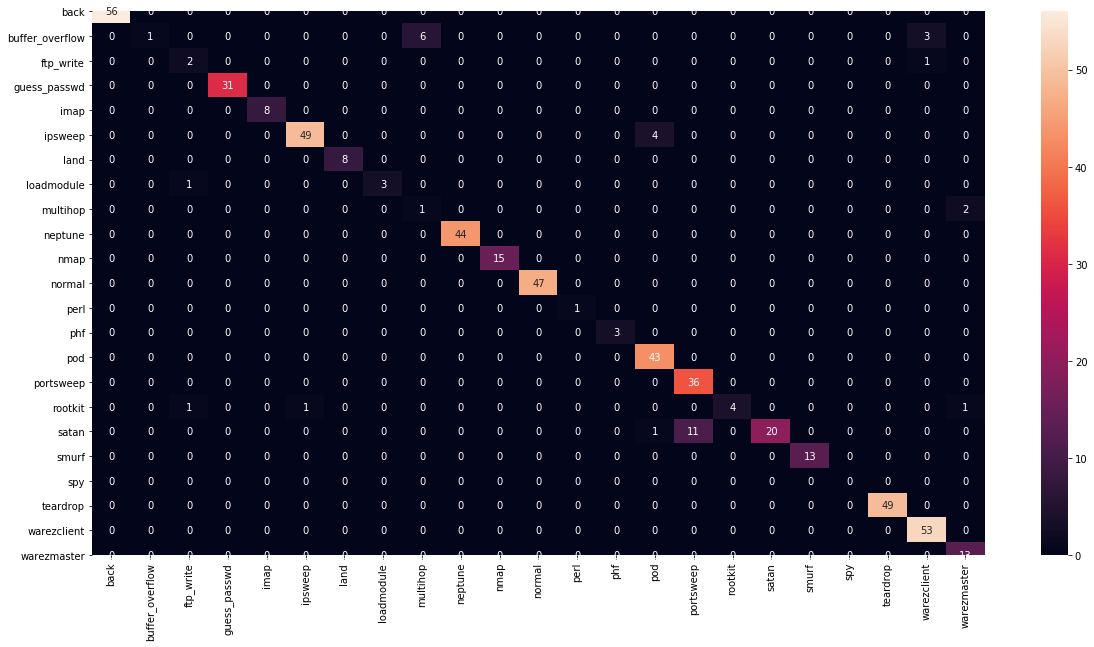

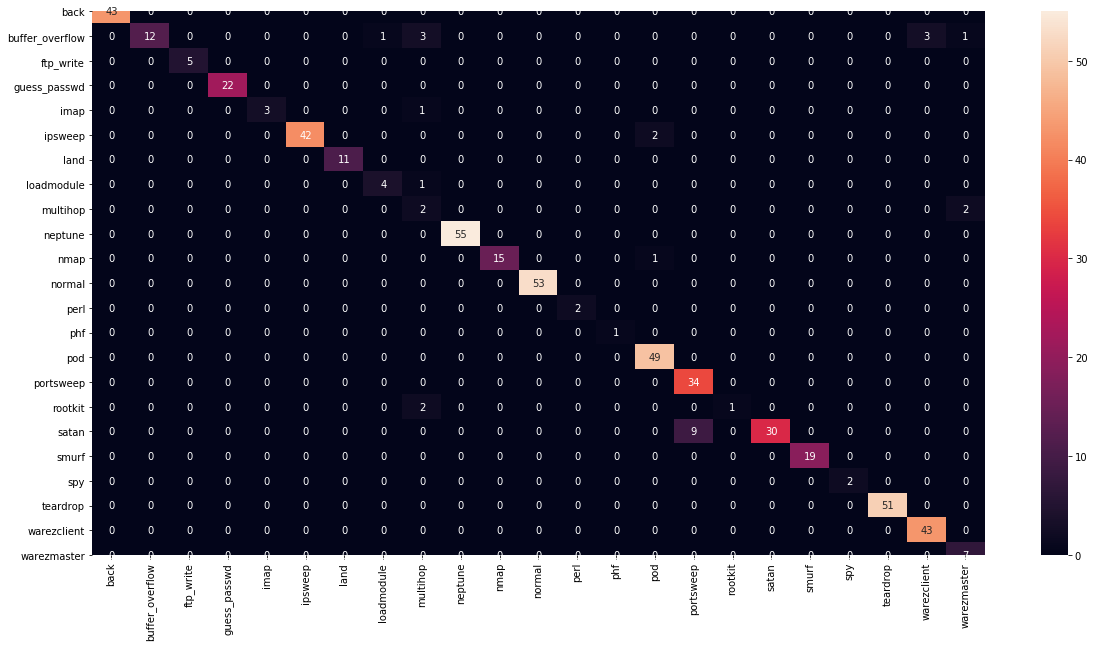

In [11]:
startime = time.time()
foldscross = 2
data_list=data.values.tolist()

results = startalgo(data_list, foldscross)
print("Correctly classified percentages:-",results)
print("average accuracy is:-",(sum(results)/float(len(results))))


endtime = time.time()
print("Time taken to complete the algorithm in seconds is:-",endtime-startime)
